In [ ]:
import pyvisa
rm = pyvisa.ResourceManager()

resources = rm.list_resources()
print("Available resources:", resources)

scope = rm.open_resource('USB0::0x0AAD::0x01D6::111986::INSTR')

idn = scope.query('*IDN?')
print("Oscilloscope IDN:", idn)

In [ ]:
# Set the file format for the screenshot (e.g., PNG, BMP, etc.)
scope.write('HCOP:DEV:LANG PNG')

In [ ]:
# Send the hardcopy command to capture the screen and transfer it directly
scope.write('HCOP:IMM; *WAI')

In [ ]:
# Fetch the binary data of the screenshot directly
screenshot_data = scope.query_binary_values('HCOP:DATA?', datatype='B', is_big_endian=True)

In [ ]:
# Save the data to a file on your computer
file_path = 'screenshot.png'
with open(file_path, 'wb') as f:
    f.write(bytearray(screenshot_data))

print(f"Screenshot saved to '{file_path}'")

# Close the connection to the oscilloscope
scope.close()

In [ ]:
from RsInstrument import *

# A good practice is to assure that you have a certain minimum version installed
RsInstrument.assert_minimum_version('1.50.0')
resource_string_1 = 'TCPIP::192.168.2.101::INSTR'  # Standard LAN connection (also called VXI-11)
resource_string_2 = 'TCPIP::192.168.2.101::hislip0'  # Hi-Speed LAN connection - see 1MA208
resource_string_3 = 'GPIB::20::INSTR'  # GPIB Connection
resource_string_4 = 'USB::0x0AAD::0x0119::022019943::INSTR'  # USB-TMC (Test and Measurement Class)
resource_string_5 = 'RSNRP::0x0095::104015::INSTR'  # R&S Powersensor NRP-Z86
resource_string_6 = 'USB0::0x0AAD::0x01D6::111986::INSTR'

# Initializing the session
instr = RsInstrument(resource_string_6)

idn = instr.query_str('*IDN?')
print(f"\nHello, I am: '{idn}'")
print(f'RsInstrument driver version: {instr.driver_version}')
print(f'Visa manufacturer: {instr.visa_manufacturer}')
print(f'Instrument full name: {instr.full_instrument_model_name}')
print(f'Instrument installed options: {",".join(instr.instrument_options)}')

# Close the session
instr.close()

In [30]:
from RsInstrument import *
instr_list = RsInstrument.list_resources("?*",'rs')
print(instr_list)

('USB0::0x0957::0x0107::MY43498293::INSTR', 'USB0::0x0AAD::0x01D6::111986::INSTR', 'ASRL1::INSTR', 'ASRL2::INSTR')


In [ ]:
resource_string_1 = 'USB0::0x0AAD::0x01D6::111986::INSTR'
instr = RsInstrument(resource_string_1,id_query=True, reset=True)
idn = instr.query_str('*IDN?')
print(f"\nHello, I am: '{idn}'")
print(f'RsInstrument driver version: {instr.driver_version}')
print(f'Visa manufacturer: {instr.visa_manufacturer}')
print(f'Instrument full name: {instr.full_instrument_model_name}')
print(f'Instrument installed options: {",".join(instr.instrument_options)}')

# Close the session
instr.close()


In [9]:
from IPython.display import display, HTML

<div style='
    background: linear-gradient(to right, #ff7e5f, #feb47b);
    color: white;
    padding: 15px;
    text-align: center;
    border-radius: 8px;
    font-family: Verdana, sans-serif;
'>
    <h1>Oscilloscope final script</h1>
</div>

Waveform data saved to 'waveform_data.csv'


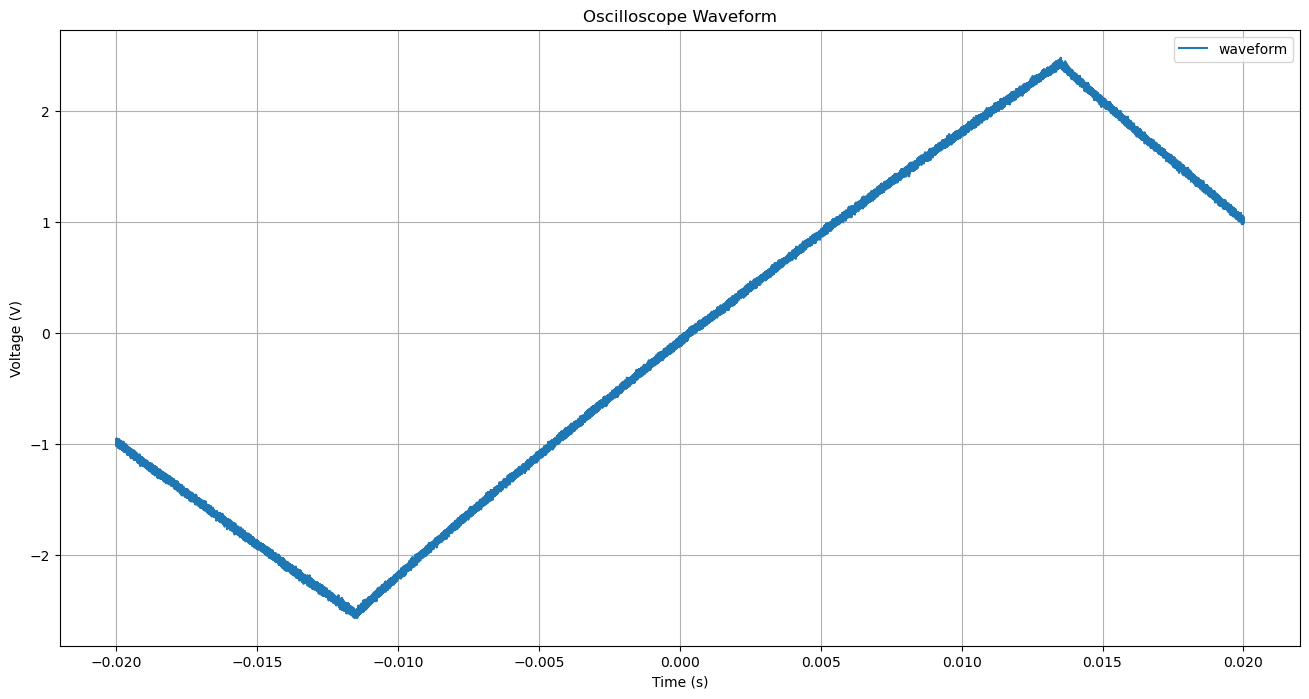

In [41]:
# final oscilloscope script
from RsInstrument import *
import numpy as np
import csv
import matplotlib.pyplot as plt
import pandas as pd

# Connect to the oscilloscope
rtb = RsInstrument('USB0::0x0AAD::0x01D6::111986::INSTR', True, True)

# -----------------------------------------------------------
# Basic Settings:
# ---------------------------- -------------------------------
rtb.write_str("TIM:ACQT 40e-3")  # Horizontal range---40ms Acquisition time
rtb.write_str("CHAN1:RANG 8")  # vertical range V 
rtb.write_str("CHAN1:OFFS 0.0")  # Offset 0
rtb.write_str("CHAN1:COUP ACL")  # Coupling AC 1MOhm
rtb.write_str("CHAN1:STAT ON")  # Switch Channel 1 ON

# -----------------------------------------------------------
# Trigger Settings:
# -----------------------------------------------------------
rtb.write_str("TRIG:A:MODE AUTO")  # Trigger Auto mode in case of no signal is applied
rtb.write_str("TRIG:A:TYPE EDGE;:TRIG:A:EDGE:SLOP POS")  # Trigger type Edge Positive
rtb.write_str("TRIG:A:SOUR CH1")  # Trigger source CH1
rtb.write_str("TRIG:A:LEV1 0.0")  # Trigger level 0.05V
rtb.query_opc()  # Using *OPC? query waits until all the instrument settings are finished

# Initiate a single acquisition and wait for it to finish
rtb.write_str_with_opc("SINGle", 3000)

# Query array of floats in ASCII format
waveform = rtb.query_bin_or_ascii_float_list('FORM ASC;:CHAN1:DATA?')

# Fetch timebase settings
x_increment = float(rtb.query('CHAN1:DATA:XINC?'))  # Horizontal scale
x_origin = float(rtb.query('CHAN1:DATA:XOR?'))  # Horizontal position

# Calculate time data
time_data = np.arange(0, len(waveform)) * x_increment + x_origin

rtb.close()

# data plotting
data = pd.DataFrame({
    'time_data': time_data,
    'waveform': waveform
})

# Save waveform data to CSV file
csv_filename = 'waveform_data.csv'
data.to_csv(csv_filename, index=False)
print(f"Waveform data saved to '{csv_filename}'")

data.plot(x='time_data', 
          y='waveform', 
          xlabel='Time (s)', 
          ylabel='Voltage (V)', 
          title='Oscilloscope Waveform', 
          figsize=(16,8),
          grid=True
          )
plt.show()

In [38]:
time_data

array([-0.01999995, -0.01999964, -0.01999933, ...,  0.01999903,
        0.01999933,  0.01999964])

In [40]:
test = pd.read_csv('waveform_data.csv')
test.tail(10)

,time_data,waveform
130198,0.019997,1.035160
130199,0.019997,1.035160
130200,0.019997,1.035160
130201,0.019998,0.996094
130202,0.019998,1.011720
130203,0.019998,1.019530
130204,0.019999,1.003910
130205,0.019999,1.019530
130206,0.019999,1.003910
130207,0.020000,0.996094
